In [1]:



import pandas as pd
import numpy as np
import jsonlines
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch_optimizer as optim
import random
from transformers import AutoModelWithLMHead, AutoTokenizer, AutoModel

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from importlib import reload
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', '{:0.3f}'.format)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.width = 0
import warnings
import torchvision
warnings.filterwarnings('ignore')

from facebook_hateful_memes_detector.utils.globals import set_global, get_global
set_global("cache_dir", "/home/ahemf/cache/cache")
set_global("dataloader_workers", 8)

from facebook_hateful_memes_detector.utils import read_json_lines_into_df, in_notebook, set_device, random_word_mask
get_global("cache_dir")
from facebook_hateful_memes_detector.models import Fasttext1DCNNModel, MultiImageMultiTextAttentionEarlyFusionModel, LangFeaturesModel, AlbertClassifer
from facebook_hateful_memes_detector.preprocessing import TextImageDataset, my_collate, get_datasets, get_image2torchvision_transforms, TextAugment
from facebook_hateful_memes_detector.preprocessing import DefinedRotation, QuadrantCut, ImageAugment
from facebook_hateful_memes_detector.preprocessing import NegativeSamplingDataset, ImageFolderDataset, ZipDatasets
from facebook_hateful_memes_detector.training import *
import facebook_hateful_memes_detector
from facebook_hateful_memes_detector.utils import get_vgg_face_model, get_torchvision_classification_models, init_fc
reload(facebook_hateful_memes_detector)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_device(device)


In [2]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_device(device)
device


device(type='cuda')

In [3]:
preprocess_easy = transforms.Compose([
    transforms.RandomGrayscale(p=0.25),
    transforms.RandomHorizontalFlip(p=0.25),
    transforms.Resize(352),
    transforms.RandomCrop(320),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224,
                                                          0.225]),
    transforms.RandomErasing(p=0.25, scale=(0.05, 0.2))
])

preprocess = transforms.Compose([
    transforms.RandomGrayscale(p=0.2),
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.RandomPerspective(distortion_scale=0.25, p=0.2),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomChoice([
        transforms.RandomRotation(15),
        DefinedRotation(90),
        transforms.RandomAffine(
            0,
            translate=(0.25, 0.25),
            scale=(0.6, 1.4),
            shear=None,
        ),
        transforms.RandomResizedCrop(480, scale=(0.6, 1.0)) # Zoom in
    ]),  
    transforms.Resize(352),
    transforms.RandomCrop(320),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224,
                                                          0.225]),
    transforms.RandomErasing(p=0.5, scale=(0.05, 0.2))
])


def torch_vectorize(fn):
    def vfn(elements):
        elements = [fn(e) for e in elements]
        return torch.stack(elements).type(torch.cuda.HalfTensor)
    return vfn
    


https://discuss.pytorch.org/t/how-to-implement-torch-optim-lr-scheduler-cosineannealinglr/28797/11

# Params

In [4]:
sgd = torch.optim.SGD
sgd_params = dict(lr=1e-4, momentum=0.9, dampening=0, weight_decay=1e-4, nesterov=False)

adam = torch.optim.Adam
adam_params = params=dict(lr=2e-4, weight_decay=1e-2)

adamw = torch.optim.AdamW
adamw_params = dict(lr=1e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-2)


In [5]:
optimizer = adam
optimizer_params = adam_params

scheduler_init_fn = get_cosine_schedule_with_warmup()
# scheduler_init_fn = None
reg_sched = get_regularizer_scheduler()
augmentation_weights = {"None": 1.0}



# Augmented/Masked Image same as Original Image - RMSE

In [6]:
lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 100,
        "7": {"lr": optimizer_params["lr"]/10},
        "8": {"lr": optimizer_params["lr"]},
        "finetune": True,
    }
}

class ImageVectorizer(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.pool = nn.AdaptiveAvgPool2d(1)
        
    def forward(self, images):
        images = images.type(torch.cuda.HalfTensor)
        output = self.pool(self.model(images)).squeeze()
        return output


In [7]:
def augment_training(model_name, epochs = 10, batch_size = 256):
    im_model = get_torchvision_classification_models(model_name, finetune=True)[0]
    dataset_org = torch.utils.data.ConcatDataset([ImageFolderDataset("../data/img/", image_transform=get_image2torchvision_transforms()),
                                                  ImageFolderDataset("../data/img/", image_transform=get_image2torchvision_transforms())])
    dataset_mod = torch.utils.data.ConcatDataset([ImageFolderDataset("../data/img/", image_transform=preprocess_easy),
                                                  ImageFolderDataset("../data/img/", image_transform=preprocess)])

    zipped_dataset = ZipDatasets([dataset_org, dataset_mod])
    
    model_fn = model_builder(ImageVectorizer,
                         dict(model=im_model),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

    model, optim = model_fn()





    _ = train_for_augment_similarity(model,
                                     optim,
                                     scheduler_init_fn,
                                     batch_size,
                                     epochs,
                                     zipped_dataset,
                                     augment_method=lambda x: x,
                                     model_call_back=None,
                                     accumulation_steps=1,
                                     collate_fn=None,
                                     plot=True)
    torch.save(model.model.state_dict(), "%s-augsim.pth" % model_name)
    return model


In [8]:
# save
# torch.save(model.model.state_dict(), "resnet18-augsim.pth")

# Contrastive Training / Distinguish between positive and negative samples

In [9]:
lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 100,
        "7": {"lr": optimizer_params["lr"]/10},
        "8": {"lr": optimizer_params["lr"]},
        "finetune": True,
    }
}

class ImageDiscriminator(torch.nn.Module):
    def __init__(self, model, dims):
        super().__init__()
        self.model = model
        self.pool = nn.AdaptiveAvgPool2d(1)
        layer1 = nn.Linear(dims * 2, dims)
        init_fc(layer1, "leaky_relu")
        layer2 = nn.Linear(dims, 2)
        init_fc(layer2, "linear")
        self.classifier = nn.Sequential(nn.Dropout(0.2), nn.LayerNorm(dims * 2), 
                                        layer1, nn.LeakyReLU(), GaussianNoise(0.5), layer2)
        self.loss = nn.CrossEntropyLoss()
        
    def forward(self, data):
        anchor, other, labels = data
        anchor = anchor.type(torch.cuda.HalfTensor)
        other = other.type(torch.cuda.HalfTensor)
        
        anchor_out = self.pool(self.model(anchor)).squeeze()
        other_out = self.pool(self.model(other)).squeeze()
        features = torch.cat([anchor_out, other_out], 1)
        logits = self.classifier(features).squeeze()
        loss = self.loss(logits, labels.to(get_device()).long())
        logits = torch.softmax(logits, dim=1)
        return logits, features, features, loss



In [10]:
def contrastive_training(model_name,
                         epochs=1,
                         batch_size=256,
                         cache_images=True,
                         dev=True):
    optimizer = sgd
    optimizer_params = sgd_params
    im_model, shapes = get_torchvision_classification_models("%s-augsim" %
                                                             model_name,
                                                             finetune=True)
    model_fn = model_builder(ImageDiscriminator,
                             dict(model=im_model, dims=shapes[0]),
                             per_param_opts_fn=lr_strategy,
                             optimiser_class=optimizer,
                             optimiser_params=optimizer_params)

    model, optim = model_fn()

    if cache_images:
        orig = ImageFolderDataset(
            "../data/img/",
            image_transform=get_image2torchvision_transforms(),
            cache_images=True)
        mods = ImageFolderDataset.from_images(orig.images,
                                              image_transform=preprocess)
        dataset = torch.utils.data.ConcatDataset([orig, mods])
    else:
        orig = ImageFolderDataset(
            "../data/img/",
            image_transform=get_image2torchvision_transforms(),
            cache_images=False)
        mods = ImageFolderDataset("../data/img/",
                                  image_transform=preprocess,
                                  cache_images=False)
        dataset = torch.utils.data.ConcatDataset([orig, mods])

    if dev:
        dataset, _ = torch.utils.data.random_split(dataset, [6_000, 14_000])
        
    dataset = NegativeSamplingDataset(dataset, negative_proportion=4)

    train_dataset, validation_dataset = torch.utils.data.random_split(
        dataset, [int(0.8 * len(dataset)),
                  int(0.2 * len(dataset))])

    train_losses, learning_rates = train(model,
                                         optim,
                                         scheduler_init_fn,
                                         batch_size,
                                         epochs,
                                         train_dataset,
                                         model_call_back=None,
                                         accumulation_steps=1,
                                         validation_strategy=None,
                                         plot=True,
                                         collate_fn=None,
                                         sampling_policy=None,
                                         class_weights=None)
    metrics = ["map", "acc", "auc"]
    val_metrics = validate(model,
                           batch_size,
                           validation_dataset,
                           collate_fn=None)[0]
    train_metrics = validate(model, batch_size, train_dataset,
                             collate_fn=None)[0]
    if not dev:
        torch.save(model.model.state_dict(), "%s-contrastive.pth" % model_name)
    return dict(train=dict(zip(metrics, train_metrics)),
                val=dict(zip(metrics, val_metrics)))


# Perform Learning

In [ ]:
model = augment_training("resnet18", epochs = 10, batch_size = 256)

Loading saved model:  resnet18-augsim.pth
Autocast =  True Epochs =  1 Divisor = 1 Examples = 80000 Batch Size =  256
Training Samples =  80000 Weighted Sampling =  False Num Batches =  313 Accumulation steps =  1



Epoch =  1 Loss = 0.475734 LR = 0.00000000



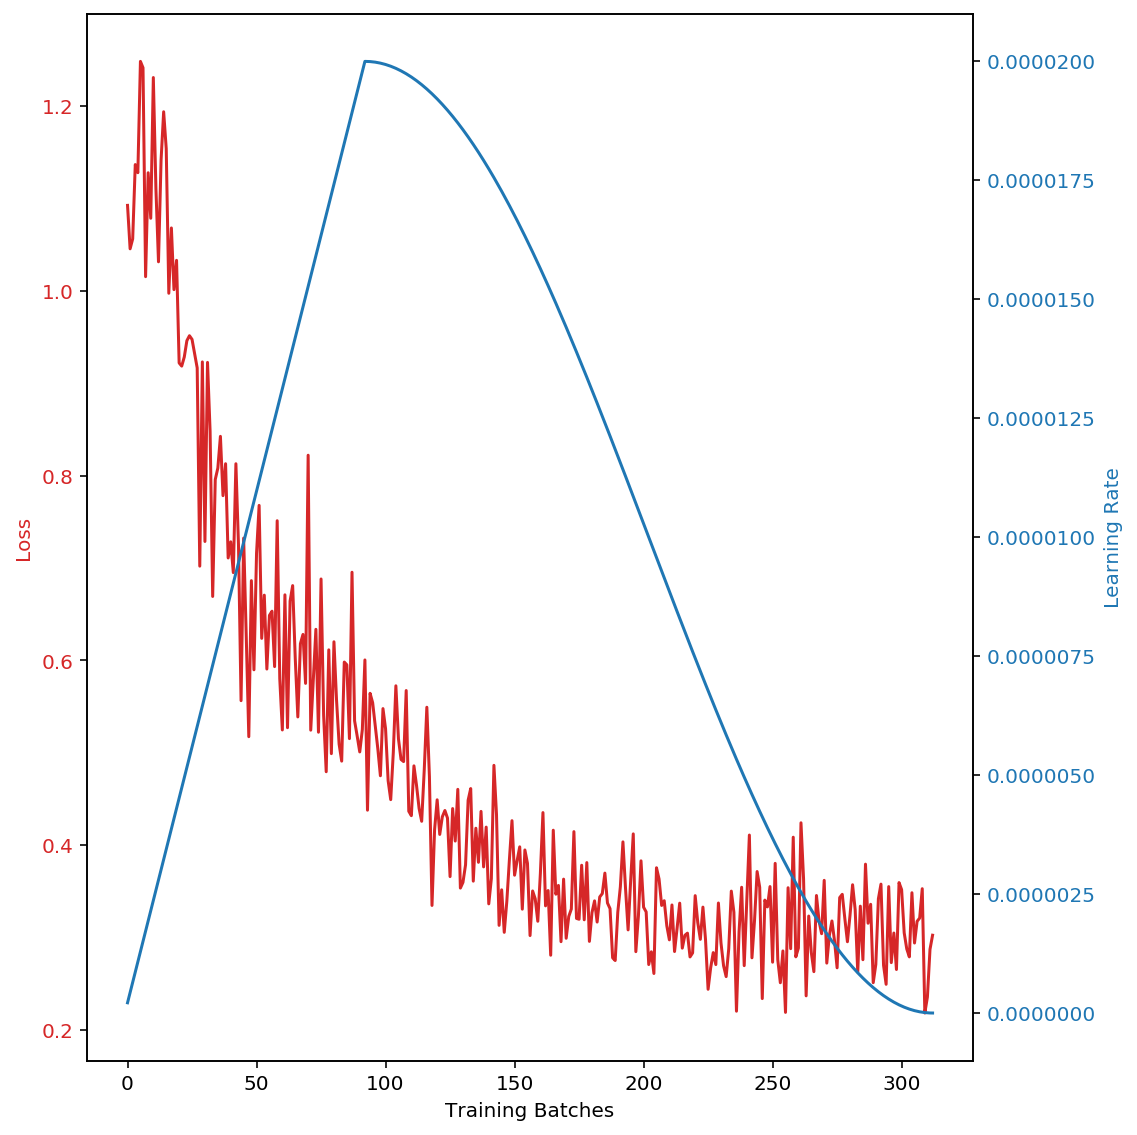

In [ ]:
contrastive_training("resnet18", epochs = 1, batch_size = 256, 
                     cache_images = False, dev = False)

In [ ]:

model = augment_training("resnet18_ssl", epochs = 10, batch_size = 256)
contrastive_training("resnet18_ssl", epochs = 1, batch_size = 256, 
                     cache_images = False, dev = False)

In [ ]:

model = augment_training("resnet50_ssl", epochs = 10, batch_size = 256)
contrastive_training("resnet50_ssl", epochs = 1, batch_size = 256, 
                     cache_images = False, dev = False)